In [1]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [2]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_laccel_z_mean.npy")
    z_var = np.load(file_path + "_laccel_z_var.npy")
    z_skew = np.load(file_path + "_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_gyro_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_mag_norm_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_gyro_z_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_mag_norm_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [3]:
Bag = load_npy("Bag")
Hips = load_npy("Hips")
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(28685, 105)

In [4]:
label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])

user2_Label = label[:14813]
user3_Label = label[14813:]

user2_Label.shape, user3_Label.shape

((14813, 1), (13872, 1))

In [5]:
user2_Bag = Bag[:14813]
user2_Hips = Hips[:14813]
user2_Torso = Torso[:14813]
user2_Hand = Hand[:14813]

user3_Bag = Bag[14813:]
user3_Hips = Hips[14813:]
user3_Torso = Torso[14813:]
user3_Hand = Hand[14813:]

In [6]:
user2_Bag_train, user2_Bag_val = train_test_split(user2_Bag, test_size=0.3, shuffle=False)
user2_Hips_train, user2_Hips_val = train_test_split(user2_Hips, test_size=0.3, shuffle=False)
user2_Torso_train, user2_Torso_val = train_test_split(user2_Torso, test_size=0.3, shuffle=False)
user2_Hand_train, user2_Hand_val = train_test_split(user2_Hand, test_size=0.3, shuffle=False)

user3_Bag_train, user3_Bag_val = train_test_split(user3_Bag, test_size=0.3, shuffle=False)
user3_Hips_train, user3_Hips_val = train_test_split(user3_Hips, test_size=0.3, shuffle=False)
user3_Torso_train, user3_Torso_val = train_test_split(user3_Torso, test_size=0.3, shuffle=False)
user3_Hand_train, user3_Hand_val = train_test_split(user3_Hand, test_size=0.3, shuffle=False)

user2_Label_train, user2_Label_val = train_test_split(user2_Label, test_size=0.3, shuffle=False)
user3_Label_train, user3_Label_val = train_test_split(user3_Label, test_size=0.3, shuffle=False)

user2_Hand_train.shape, user2_Hand_val.shape, user3_Hand_train.shape, user3_Hand_val.shape, user2_Label_train.shape, user2_Label_val.shape

((10369, 105), (4444, 105), (9710, 105), (4162, 105), (10369, 1), (4444, 1))

In [ ]:
def load_npy():
    file_path = "../Output/test/test"
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [7]:
def load_npy():
    file_path = "../Output/test/test"    
    xy_mean = np.load(file_path + "_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_laccel_z_mean.npy")
    z_var = np.load(file_path + "_laccel_z_var.npy")
    z_skew = np.load(file_path + "_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_gyro_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_mag_norm_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_gyro_z_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_mag_norm_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [8]:
test = load_npy()
test.shape

(57573, 105)

In [9]:
Y_train = [0] * user2_Bag_train.shape[0] + [1] * user2_Bag_train.shape[0] + [2] * user2_Bag_train.shape[0] + [3] * user2_Bag_train.shape[0] + \
        [0] * user3_Bag_train.shape[0] + [1] * user3_Bag_train.shape[0] + [2] * user3_Bag_train.shape[0] + [3] * user3_Bag_train.shape[0]
Y_train = np.array(Y_train).reshape([-1, 1])

Y_val = [0] * user2_Bag_val.shape[0] + [1] * user2_Bag_val.shape[0] + [2] * user2_Bag_val.shape[0] + [3] * user2_Bag_val.shape[0] + \
        [0] * user3_Bag_val.shape[0] + [1] * user3_Bag_val.shape[0] + [2] * user3_Bag_val.shape[0] + [3] * user3_Bag_val.shape[0]
Y_val = np.array(Y_val).reshape([-1, 1])

Y_train.shape, Y_val.shape

((80316, 1), (34424, 1))

In [10]:
user2_Label_train = np.concatenate([user2_Label_train, user2_Label_train, user2_Label_train, user2_Label_train], axis=0)
user2_Label_val = np.concatenate([user2_Label_val, user2_Label_val, user2_Label_val, user2_Label_val], axis=0)
user3_Label_train = np.concatenate([user3_Label_train, user3_Label_train, user3_Label_train, user3_Label_train], axis=0)
user3_Label_val = np.concatenate([user3_Label_val, user3_Label_val, user3_Label_val, user3_Label_val], axis=0)

Y_train = np.concatenate([Y_train, np.concatenate([user2_Label_train, user3_Label_train], axis=0)], axis=1)
Y_val = np.concatenate([Y_val, np.concatenate([user2_Label_val, user3_Label_val], axis=0)], axis=1)

Y_train.shape, Y_val.shape

((80316, 2), (34424, 2))

In [11]:
X_train = np.concatenate([user2_Bag_train, user2_Hips_train, user2_Torso_train, user2_Hand_train, user3_Bag_train, user3_Hips_train, user3_Torso_train, user3_Hand_train])
X_val = np.concatenate([user2_Bag_val, user2_Hips_val, user2_Torso_val, user2_Hand_val, user3_Bag_val, user3_Hips_val, user3_Torso_val, user3_Hand_val])

X_train.shape, X_val.shape

((80316, 105), (34424, 105))

In [12]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
model.fit(X_train[(Y_train[:, 1] <= 3) & (Y_train[:, 1] > 1)], Y_train[(Y_train[:, 1] <= 3) & (Y_train[:, 1] > 1)][:, 0])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=0.9, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [13]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

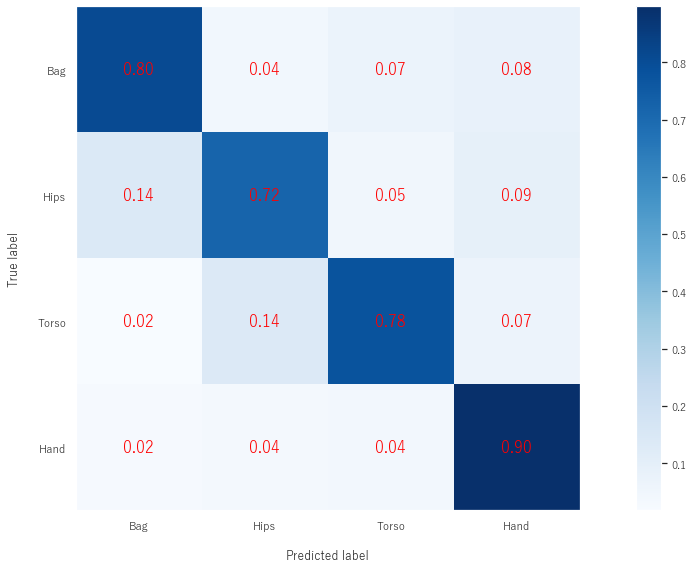

In [14]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X_val)
plot_confusion_matrix(Y_val[(Y_val[:, 1] <= 3) & (Y_val[:, 1] > 1)][:, 0], predict[(Y_val[:, 1] <= 3) & (Y_val[:, 1] > 1)], class_names, True)
plt.grid(False)

In [15]:
predict = model.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i)))

Bag：14358
Hips：9674
Torso：11639
Hand：21902


# Validationデータをすべて学習させる

In [16]:
X = np.concatenate([X_train, X_val], axis=0)
Y = np.concatenate([Y_train, Y_val], axis=0)
X.shape, Y.shape

((114740, 105), (114740, 2))

In [18]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
model.fit(X[(Y[:, 1] <= 3) & (Y[:, 1] > 1)], Y[(Y[:, 1] <= 3) & (Y[:, 1] > 1)][:, 0])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=0.9, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

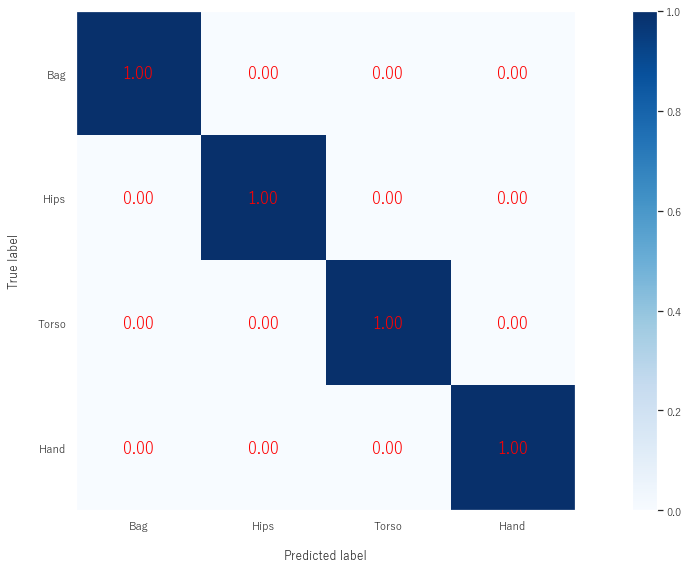

In [20]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X[(Y[:, 1] <= 3) & (Y[:, 1] > 1)])
plot_confusion_matrix(Y[(Y[:, 1] <= 3) & (Y[:, 1] > 1)][:, 0], predict, class_names, True)
plt.grid(False)

In [21]:
predict = model.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i)))

Bag：16805
Hips：4886
Torso：15847
Hand：20035


## ここで満を持してtestデータの出力確率が75%以上のWalkingかRunだと思われるサンプルだけで保持位置を推定！

In [22]:
a = np.load("test_walking_run_index.npy")
a.shape

(8999,)

In [56]:
predict = model.predict_proba(test[a])

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict[:, i]>=0.75)))

NameError: name 'test' is not defined

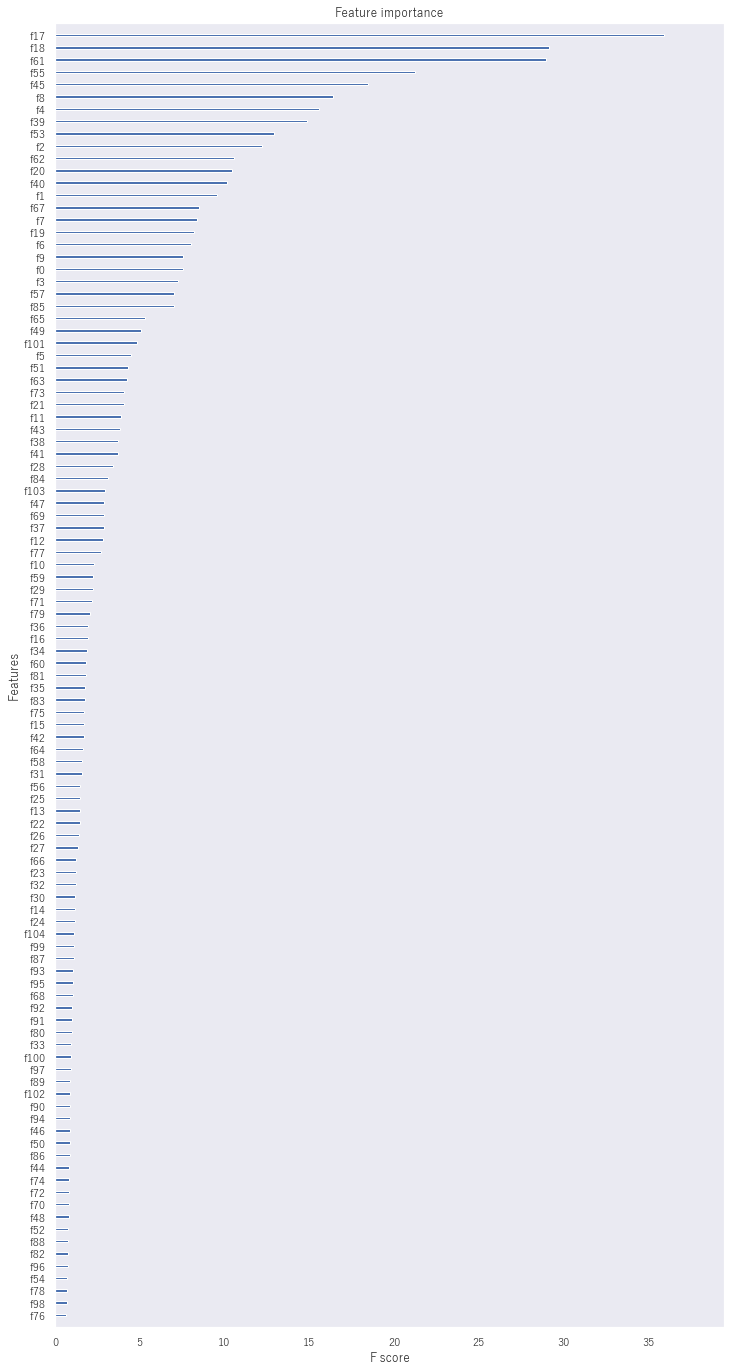

In [34]:
_, ax = plt.subplots(figsize=(12, 24))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.grid(False)

In [35]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Trainデータで保持位置決定精度を調査

In [36]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [37]:
def load_npy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_glo_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_glo_gyro_z_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_glo_mag_norm_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_glo_mag_norm_ver2_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [38]:
Bag = load_npy("Bag")
Hips = load_npy("Hips")
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(195491, 105)

In [41]:
Label = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0].reshape([-1, 1])
Label.shape

(195491, 1)

In [42]:
Bag_train, Bag_val = train_test_split(Bag, test_size=0.7, shuffle=False)
Hips_train, Hips_val = train_test_split(Hips, test_size=0.7, shuffle=False)
Torso_train, Torso_val = train_test_split(Torso, test_size=0.7, shuffle=False)
Hand_train, Hand_val = train_test_split(Hand, test_size=0.7, shuffle=False)
Label_train, Label_val = train_test_split(Label, test_size=0.7, shuffle=False)

Hand_train.shape, Hand_val.shape

((58647, 105), (136844, 105))

In [40]:
Y_train = [0] * 58647 + [1] * 58647 + [2] * 58647 + [3] * 58647
Y_train = np.array(Y_train).reshape([-1, 1])

Y_val = [0] * 136844 + [1] * 136844 + [2] * 136844 + [3] * 136844
Y_val = np.array(Y_val).reshape([-1, 1])

Y_train.shape, Y_val.shape

((234588, 1), (547376, 1))

In [46]:
X_train = np.concatenate([Bag_train, Hips_train, Torso_train, Hand_train])
X_val = np.concatenate([Bag_val, Hips_val, Torso_val, Hand_val])

X_train.shape, X_val.shape

((234588, 105), (547376, 105))

In [43]:
Label_train = np.concatenate([Label_train, Label_train, Label_train, Label_train], axis=0)
Label_val = np.concatenate([Label_val, Label_val, Label_val, Label_val], axis=0)

Label_train.shape, Label_val.shape

((234588, 1), (547376, 1))

In [44]:
Y_train = np.concatenate([Y_train, Label_train], axis=1)
Y_val = np.concatenate([Y_val, Label_val], axis=1)

Y_train.shape, Y_val.shape

((234588, 2), (547376, 2))

In [47]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0, n_estimator=50)
model.fit(X_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)], Y_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)][:, 0])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimator=50, n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, sub_sample=0.9, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [48]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

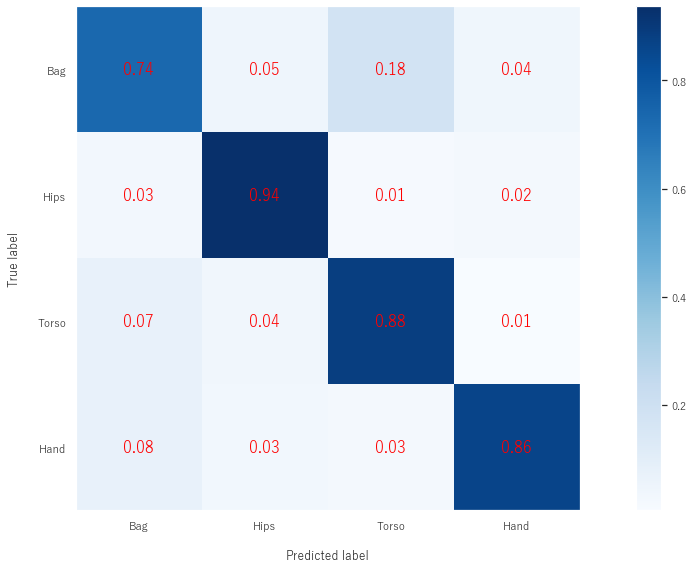

In [55]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)])
plot_confusion_matrix(Y_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)][:, 0], predict, class_names, True)
plt.grid(False)

In [79]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# trainデータ全部学習→validationデータの保持位置推定の精度を確認

In [111]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [112]:
def load_npy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_glo_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_glo_gyro_z_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_glo_mag_norm_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_glo_mag_norm_ver2_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [113]:
Bag = load_npy("Bag")
Hips = np.delete(load_npy("Hips"), 120845, 0)
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(195491, 105)

In [114]:
X_train = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
Y_train = [0] * 195491 + [1] * 195490 + [2] * 195491 + [3] * 195491
Y_train = np.array(Y_train).reshape([-1, 1])
Label = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0].reshape([-1, 1])
Label = np.concatenate([Label, np.delete(Label, 120845, 0), Label, Label], axis=0)

Y_train = np.concatenate([Y_train, Label], axis=1)
del Label
X_train.shape, Y_train.shape

((781963, 105), (781963, 2))

In [115]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_glo_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_glo_gyro_z_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_glo_mag_norm_ver2_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_ver2_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_glo_mag_norm_ver2_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [116]:
Bag = load_npy("Bag")
Hips = load_npy("Hips")
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(28685, 105)

In [117]:
X_val = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
Y_val = [0] * 28685 + [1] * 28685 + [2] * 28685 + [3] * 28685
Y_val = np.array(Y_val).reshape([-1, 1])
Label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
Label = np.concatenate([Label, Label, Label, Label], axis=0)

Y_val = np.concatenate([Y_val, Label], axis=1)
del Label
X_val.shape, Y_val.shape

((114740, 105), (114740, 2))

In [118]:
std = StandardScaler()

X_train[(Y_train[:, 1] > 1) | (Y_train[:, 1] <= 3)][:, :39] = std.fit_transform(X_train[(Y_train[:, 1] > 1) | (Y_train[:, 1] <= 3)][:, :39])
X_train[(Y_train[:, 1] > 1) | (Y_train[:, 1] <= 3)][:, [i for i in range(40, X_train.shape[1], 2)]] = std.fit_transform(X_train[(Y_train[:, 1] > 1) | (Y_train[:, 1] <= 3)][:, [i for i in range(40, X_train.shape[1], 2)]])

X_val[(Y_val[:, 1] > 1) | (Y_val[:, 1] <= 3)][:, :39] = std.fit_transform(X_val[(Y_val[:, 1] > 1) | (Y_val[:, 1] <= 3)][:, :39])
X_val[(Y_val[:, 1] > 1) | (Y_val[:, 1] <= 3)][:, [i for i in range(40, X_val.shape[1], 2)]] = std.fit_transform(X_val[(Y_val[:, 1] > 1) | (Y_val[:, 1] <= 3)][:, [i for i in range(40, X_val.shape[1], 2)]])

X_train.shape, X_val.shape

((781963, 105), (114740, 105))

In [119]:
learns = []
tests = []

for i in range(4):
    tmp = np.where(Y_train[:, 0] == i)[0]
    learns.append(tmp[:tmp.shape[0]//10*7])
    tests.append(tmp[tmp.shape[0]//10*7:])
    
learns, tests, len(learns[0]), len(tests[0])

([array([     0,      1,      2, ..., 136840, 136841, 136842], dtype=int64),
  array([195491, 195492, 195493, ..., 332331, 332332, 332333], dtype=int64),
  array([390981, 390982, 390983, ..., 527821, 527822, 527823], dtype=int64),
  array([586472, 586473, 586474, ..., 723312, 723313, 723314], dtype=int64)],
 [array([136843, 136844, 136845, ..., 195488, 195489, 195490], dtype=int64),
  array([332334, 332335, 332336, ..., 390978, 390979, 390980], dtype=int64),
  array([527824, 527825, 527826, ..., 586469, 586470, 586471], dtype=int64),
  array([723315, 723316, 723317, ..., 781960, 781961, 781962], dtype=int64)],
 136843,
 58648)

In [120]:
x_train = X_train[learns[0]]
y_train = Y_train[learns[0]]
x_val = X_train[tests[0]]
y_val = Y_train[tests[0]]

for i in range(1, len(learns)):
    x_train = np.concatenate([x_train, X_train[learns[i]]])
    y_train = np.concatenate([y_train, Y_train[learns[i]]])
    
    x_val = np.concatenate([x_val, X_train[tests[i]]])
    y_val = np.concatenate([y_val, Y_train[tests[i]]])
    
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((547372, 105), (547372, 2), (234591, 105), (234591, 2))

In [121]:
evals_result = {}

model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0, n_estimator=10000)
model.fit(x_train[(y_train[:, 1] > 1) & (y_train[:, 1] <= 3)], y_train[(y_train[:, 1] > 1) & (y_train[:, 1] <= 3)][:, 0], 
          early_stopping_rounds=30, 
          eval_set=[(x_train[(y_train[:, 1] > 1) & (y_train[:, 1] <= 3)], y_train[(y_train[:, 1] > 1) & (y_train[:, 1] <= 3)][:, 0]), 
                    (x_val[(y_val[:, 1] > 1) & (y_val[:, 1] <= 3)], y_val[(y_val[:, 1] > 1) & (y_val[:, 1] <= 3)][:, 0])], eval_metric='merror', verbose=False, 
          callbacks=[xgb.callback.record_evaluation(evals_result)])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimator=10000, n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, sub_sample=0.9,
              subsample=1, tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

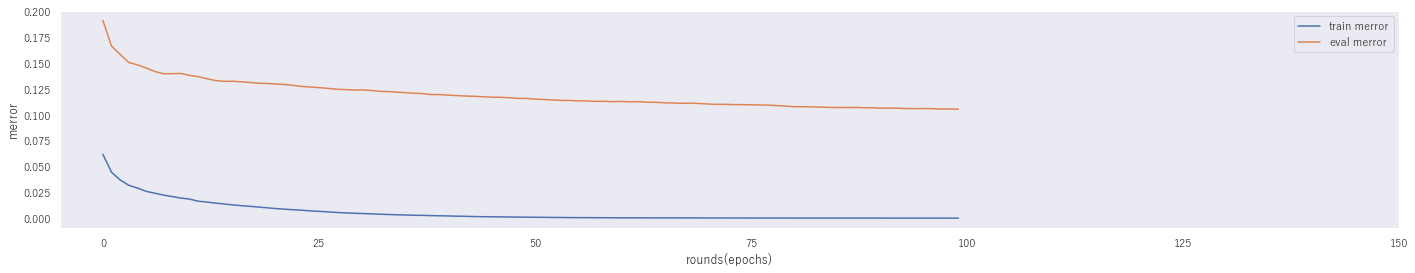

In [123]:
# 学習過程の名前は 'validation_{n}' になる
plt.figure(figsize=(24, 4))
train_metric = evals_result['validation_0']['merror']
plt.plot(train_metric, label='train merror')
eval_metric = evals_result['validation_1']['merror']
plt.plot(eval_metric, label='eval merror')
plt.grid()
plt.legend()
plt.xlabel('rounds(epochs)')
plt.ylabel('merror')
plt.xticks(np.arange(0, 150+1, 25))
plt.show()

In [124]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

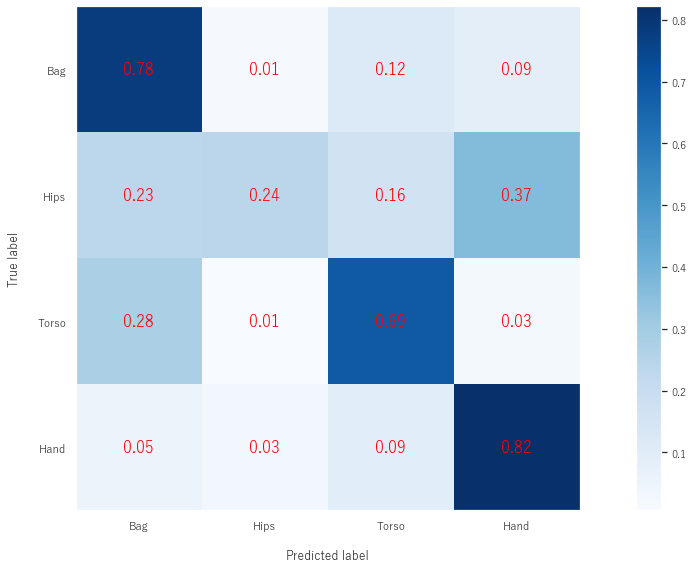

In [125]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)])
plot_confusion_matrix(Y_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)][:, 0], predict, class_names, True)
plt.grid(False)

In [126]:
def load_npy():
    file_path = "../Output/test/test"    
    xy_mean = np.load(file_path + "_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_laccel_z_mean.npy")
    z_var = np.load(file_path + "_laccel_z_var.npy")
    z_skew = np.load(file_path + "_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_laccel_z_kurtosis.npy")
    z_lacc_FFT_sum = np.load(file_path + "_laccel_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT_sum = np.load(file_path + "_gyro_z_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    norm_mag_FFT_sum = np.load(file_path + "_mag_norm_sum_frequency_range5Hz.npy")[:, 0:-1:2]
    z_lacc_FFT = np.load(file_path + "_laccel_z_amplitude_frequency_range5Hz.npy")
    z_gyro_FFT = np.load(file_path + "_gyro_z_amplitude_frequency_range5Hz.npy")
    norm_mag_FFT = np.load(file_path + "_mag_norm_amplitude_frequency_range5Hz.npy")
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), \
                             z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_lacc_FFT, z_gyro_FFT, norm_mag_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_lacc_FFT_sum, z_gyro_FFT_sum, norm_mag_FFT_sum, z_gyro_FFT, norm_mag_FFT
    return result

In [127]:
test = load_npy()
test.shape

(57573, 105)

In [128]:
a = np.load("test_walking_run_index.npy")
a.shape

(8999,)

In [129]:
test = test[a]
test.shape

(8999, 105)

In [130]:
test[:, :39] = std.fit_transform(test[:, :39])
test[:, [i for i in range(40, test.shape[1], 2)]] = std.fit_transform(test[:, [i for i in range(40, test.shape[1], 2)]])

test.shape

(8999, 105)

In [139]:
predict = model.predict_proba(X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)])

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict[:, i]>=0.70)))

Bag：5307
Hips：684
Torso：4087
Hand：5649


In [140]:
predict = model.predict_proba(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict[:, i]>=0.75)))

Bag：1032
Hips：0
Torso：0
Hand：843


## trainデータ全部学習させて、validationデータをvalidationにする

In [141]:
evals_result = {}

model = xgb.XGBClassifier(max_depth=18, min_child_weight=7, learning_rate=0.1, gamma=0.005, sub_sample=0.9, colsample_bytree=0.8, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0, n_estimator=10000)
model.fit(X_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)], Y_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)][:, 0], 
          early_stopping_rounds=30, 
          eval_set=[(X_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)], Y_train[(Y_train[:, 1] > 1) & (Y_train[:, 1] <= 3)][:, 0]), 
                    (X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)], Y_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)][:, 0])], eval_metric='merror', verbose=False, 
          callbacks=[xgb.callback.record_evaluation(evals_result)])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.005, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimator=10000, n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, sub_sample=0.9,
              subsample=1, tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

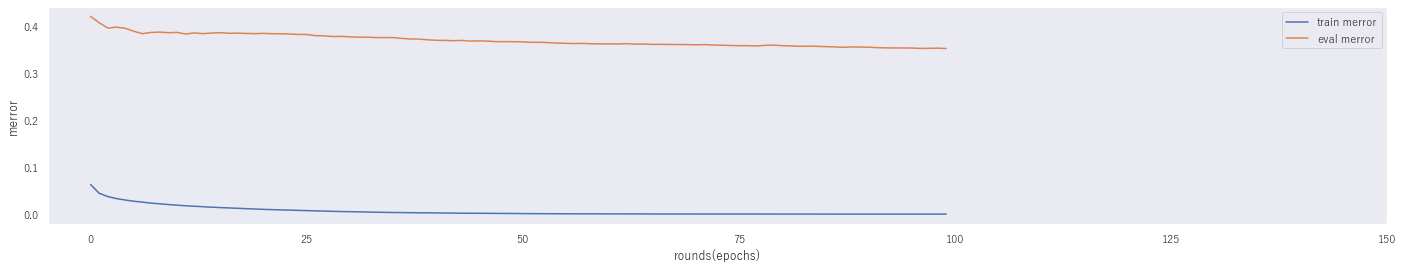

In [142]:
# 学習過程の名前は 'validation_{n}' になる
plt.figure(figsize=(24, 4))
train_metric = evals_result['validation_0']['merror']
plt.plot(train_metric, label='train merror')
eval_metric = evals_result['validation_1']['merror']
plt.plot(eval_metric, label='eval merror')
plt.grid()
plt.legend()
plt.xlabel('rounds(epochs)')
plt.ylabel('merror')
plt.xticks(np.arange(0, 150+1, 25))
plt.show()

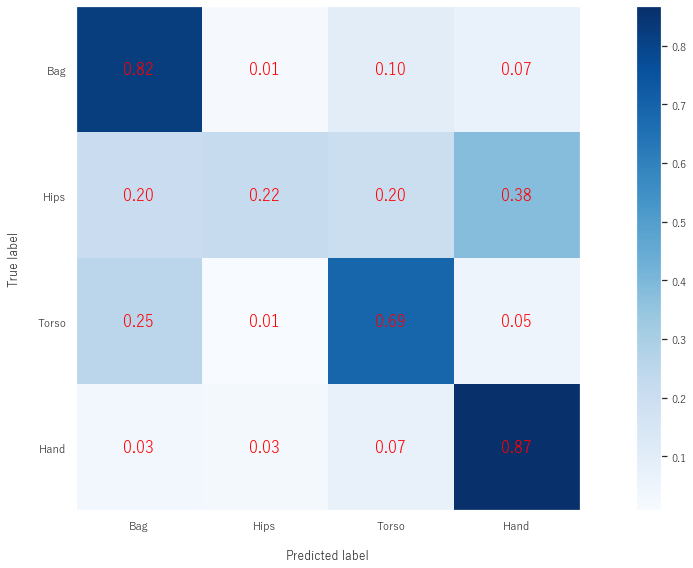

In [144]:
class_names = ['Bag', 'Hips', 'Torso', 'Hand']

predict = model.predict(X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)])
plot_confusion_matrix(Y_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)][:, 0], predict, class_names, True)
plt.grid(False)

In [143]:
predict = model.predict_proba(X_val[(Y_val[:, 1] > 1) & (Y_val[:, 1] <= 3)])

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict[:, i]>=0.70)))

Bag：5411
Hips：633
Torso：4118
Hand：5975


In [147]:
predict = model.predict_proba(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict[:, i]>=0.75)))

Bag：2006
Hips：0
Torso：58
Hand：20
